In [1]:
print("strawberry")

strawberry


In [2]:
import torch
import numpy as np

# dataset
from twaidata.torchdatasets.in_ram_ds import MRISegmentation2DDataset, MRISegmentation3DDataset
from torch.utils.data import DataLoader, random_split, ConcatDataset

# model
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_deterministic import HyperMapp3r
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_DDU import HyperMapp3rDDU
from trustworthai.models.uq_models.initial_variants.HyperMapp3r_SSN import HyperMapp3rSSN


# augmentation and pretrain processing
from trustworthai.utils.augmentation.standard_transforms import RandomFlip, GaussianBlur, GaussianNoise, \
                                                            RandomResizeCrop, RandomAffine, \
                                                            NormalizeImg, PairedCompose, LabelSelect, \
                                                            PairedCentreCrop, CropZDim
# loss function
from trustworthai.utils.losses_and_metrics.per_individual_losses import (
    dice_loss,
    log_cosh_dice_loss,
    TverskyLoss,
    FocalTverskyLoss,
    DiceLossMetric
)
from torch.nn import BCELoss, MSELoss, BCEWithLogitsLoss

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import pytorch_lightning as pl

# misc
import os
import torch
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
import torch.distributions as td

In [3]:
torch.autograd.set_detect_anomaly(True)

### Set the seed

In [4]:
seed = 3407
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### define datasets and dataloaders

In [5]:
is3D = False

In [6]:
root_dir = "/disk/scratch/s2208943/ipdis/preprep/out_data/collated/"
#root_dir = "/media/benp/NVMEspare/datasets/preprocessing_attempts/local_results/collated/"
wmh_dir = root_dir + "WMH_challenge_dataset/"
ed_dir = root_dir + "EdData/"

In [7]:
# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ]

# domains = [
#             wmh_dir + d for d in ["Singapore", "Utrecht", "GE3T"]
#           ] + [
#             ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
#           ]


domains = [
            ed_dir + d for d in ["domainA", "domainB", "domainC", "domainD"]
          ]

In [8]:
# augmentation definintion
def get_transforms(is_3D):
    transforms = [
        LabelSelect(label_id=1),
        RandomFlip(p=0.5, orientation="horizontal"),
        # GaussianBlur(p=0.5, kernel_size=7, sigma=(.1, 1.5)),
        # GaussianNoise(p=0.2, mean=0, sigma=0.2),
        # RandomAffine(p=0.2, shear=(.1,3.)),
        # RandomAffine(p=0.2, degrees=5),
        #RandomResizeCrop(p=1., scale=(0.6, 1.), ratio=(3./4., 4./3.))
        RandomResizeCrop(p=1., scale=(0.3, 0.5), ratio=(3./4., 4./3.)) # ssn
    ]
    if not is_3D:
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)
    else:
        transforms.append(CropZDim(size=32, minimum=0, maximum=-1))
        transforms.append(lambda x, y: (x, y.squeeze().type(torch.long)))
        return PairedCompose(transforms)

In [9]:
# function to do train validate test split
test_proportion = 0.1
validation_proportion = 0.2

def train_val_test_split(dataset, val_prop, test_prop, seed):
    # I think the sklearn version might be prefereable for determinism and things
    # but that involves fiddling with the dataset implementation I think....
    size = len(dataset)
    test_size = int(test_prop*size) 
    val_size = int(val_prop*size)
    train_size = size - val_size - test_size
    train, val, test = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(seed))
    return train, val, test

In [10]:
# load datasets
# this step is quite slow, all the data is being loaded into memory
if is3D:
    datasets_domains = [MRISegmentation3DDataset(root_dir, domain, transforms=get_transforms(is_3D=True)) for domain in domains]
else:
    datasets_domains = [MRISegmentation2DDataset(root_dir, domain, transforms=get_transforms(is_3D=False)) for domain in domains]

# split into train, val test datasets
datasets = [train_val_test_split(dataset, validation_proportion, test_proportion, seed) for dataset in datasets_domains]

# concat the train val test datsets
train_dataset = ConcatDataset([ds[0] for ds in datasets])
val_dataset = ConcatDataset([ds[1] for ds in datasets])
test_dataset = ConcatDataset([ds[2] for ds in datasets])

In [11]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8743, 2497, 1248)

In [12]:
# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size = 16, shuffle=False, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

### setup model

In [13]:
import torch
import torch.nn as nn
from trustworthai.models.uq_models.drop_UNet import normalization_layer
import torch.nn.functional as F
import torch.distributions as td
from typing import Tuple


def get_conv_func(dims, transpose=False):
    # determine convolution func
        if dims == 2:
            if transpose:
                return nn.ConvTranspose2d
            else:
                return nn.Conv2d
        elif dims == 3:
            if transpose:
                return nn.ConvTranspose3d
            else:
                return nn.Conv3d
        else:
            raise ValueError(f"values of dims of 2 or 3 (2D or 2D conv) are supported only, not {dims}")
            
def get_dropout_func(dims):
    if dims == 2:
        return nn.Dropout2d
    if dims == 3:
        return nn.Dropout3d
    else:
        return nn.Dropout

class ReshapedDistribution(td.Distribution):
    def __init__(self, base_distribution: td.Distribution, new_event_shape: Tuple[int, ...]):
        super().__init__(batch_shape=base_distribution.batch_shape, event_shape=new_event_shape, validate_args=False)
        self.base_distribution = base_distribution
        self.new_shape = base_distribution.batch_shape + new_event_shape
        
        #print("base distribution: ", self.base_distribution)

    @property
    def support(self):
        return self.base_distribution.support

    @property
    def arg_constraints(self):
        return self.base_distribution.arg_constraints()

    @property
    def mean(self):
        return self.base_distribution.mean.view(self.new_shape)

    @property
    def variance(self):
        return self.base_distribution.variance.view(self.new_shape)

    def rsample(self, sample_shape=torch.Size()):
        return self.base_distribution.rsample(sample_shape).view(sample_shape + self.new_shape)

    def log_prob(self, value):
        return self.base_distribution.log_prob(value.view(self.batch_shape + (-1,)))

    def entropy(self):
        return self.base_distribution.entropy()    
    
class HyperMapp3rSSN2(HyperMapp3r):
    def __init__(self, dims=3,
                 in_channels=3,
                 out_channels=1,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=True,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False
                ):
        super().__init__(dims=dims,
                 in_channels=in_channels,
                 out_channels=decoder_features[-1], # last layer of just keeps number of nodes fixed this time
                 encoder_features=encoder_features,
                 decoder_features=decoder_features,
                 softmax=False,
                 up_res_blocks=up_res_blocks,
                 block_params=block_params)
        
        print("WARNING: this model assumes that the input to the model contains the brain mask in the first channel!")
        conv_func = get_conv_func(dims, transpose=False)
        self.ssn_rank = ssn_rank
        self.ssn_diagonal = ssn_diagonal
        self.ssn_epsilon = ssn_epsilon
        self.ssn_num_classes = out_channels
        
        self.lrelu = nn.LeakyReLU(0.01)
        
        self.mean_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) *  dims, padding='same')
        self.log_cov_diag_l = conv_func(decoder_features[-1], out_channels, kernel_size = (1,) * dims, padding='same')
        self.cov_factor_l = conv_func(decoder_features[-1], out_channels * ssn_rank, kernel_size = (1,) * dims, padding='same')

    def forward(self, x):
        logits = self.lrelu(super().forward(x))
        if torch.sum(torch.isnan(logits)) > 0:
            print("NAN 1", torch.sum(torch.isnan(logits)))
        batch_size = logits.shape[0]
        event_shape = (self.ssn_num_classes,) + logits.shape[2:]
        
        mean = self.mean_l(logits)
        mean = mean.view((batch_size, -1))
        
        cov_diag = self.log_cov_diag_l(logits).exp() + self.ssn_epsilon
        cov_diag = cov_diag.view((batch_size, -1))
        
        cov_factor = self.cov_factor_l(logits)
        cov_factor = cov_factor.view((batch_size, self.ssn_rank, self.ssn_num_classes, -1))
        cov_factor = cov_factor.flatten(2,3)
        cov_factor = cov_factor.transpose(1,2)
        if torch.sum(torch.isnan(mean)) > 0:
            print("NAN 2")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 3")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 4")
        
        # covariance tends to blow up to infinity, hence set to 0 outside the ROI
        mask = x[:,1]
        mask = mask.unsqueeze(1).expand((batch_size, self.ssn_num_classes) + mask.shape[1:]).reshape(batch_size, -1)
        cov_factor = cov_factor * mask.unsqueeze(-1)
        cov_diag = cov_diag * mask + self.ssn_epsilon
        
        if torch.sum(torch.isnan(mask)) > 0:
            print("NAN 5")
        if torch.sum(torch.isnan(cov_factor)) > 0:
            print("NAN 6")
        if torch.sum(torch.isnan(cov_diag)) > 0:
            print("NAN 7")
        
        if self.ssn_diagonal:
            base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)), 1)
        else:
            try:
                base_distribution = td.LowRankMultivariateNormal(loc=mean, cov_factor=cov_factor, cov_diag=cov_diag)
                #print("using multivariate normal!")
            except Exception as e:
                print("was thrown: ", e)
                print('hmm: Covariance became non invertible using independent normals for this batch!')
                print("cov diag okay: ", torch.sum(cov_diag <=0))
                print("sqrt cov diag okay: ", torch.sum(torch.sqrt(cov_diag) <=0))
                
                try:
                    base_distribution = td.Independent(td.Normal(loc=mean, scale=torch.sqrt(cov_diag)),1)
                except Exception as e:
                    print("second fail: ", e)
                    print(torch.min(torch.sqrt(cov_diag), torch.max(torch.sqrt(cov_diag))))
        
        distribution = ReshapedDistribution(base_distribution, event_shape)
        
        shape = (batch_size,) + event_shape
        logit_mean_view = mean.view(shape).detach()
        cov_diag_view = cov_diag.view(shape).detach()
        cov_factor_view = cov_factor.transpose(2,1).view((batch_size, self.ssn_num_classes * self.ssn_rank) + event_shape[1:]).detach()
        
        
        output_dict = {
            'logit_mean':logit_mean_view,
            'cov_diag':cov_diag_view,
            'cov_factor':cov_factor_view,
            'distribution':distribution,
        }
        
        return output_dict

In [14]:
in_channels = 3
out_channels = 1

if is3D:
    pass
else:
    # encoder_features=[16, 32, 64, 128, 256] # orig: [16, 32, 64, 128, 256]
    # decoder_features=encoder_features[::-1][1:]
    model_raw = HyperMapp3rSSN2(dims=2,
                 in_channels=3,
                 out_channels=2,
                 encoder_features=[16, 32, 64, 128, 256],
                 decoder_features=[128, 64, 32, 16],
                 softmax=False,
                 up_res_blocks=False,
                 block_params={
                     "dropout_p":0.1,
                     "norm_type":"in", 
                     "dropout_both_layers":False,
                 },
                 ssn_rank = 10,
                 ssn_epsilon=1e-5,
                 ssn_diagonal=False)
    
    
    optimizer_params={"lr":2e-3}
    lr_scheduler_params={"step_size":20, "gamma":0.1}
    # optimizer_params={"lr":2e-3, "momentum":0.6}
    # optimizer = torch.optim.RMSprop
    # lr_scheduler_params={"milestones":[10,100,200], "gamma":0.5}
    # lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR


In [15]:
### functions for getting code from the evidential distribution. Nice.

def relu_evidence(logits):
    return torch.nn.functional.relu(logits)

def exp_evidence(logits):
    return logits.clamp(-10, 10).exp()

def softplus_evidence(logits):
    return torch.nn.functional.softplus(logits)


def get_S(evidence):
    # evidence is shape [b, c, <dims>], we want an S per pixel, so reduce on dim 1
    S = (evidence + 1.).sum(dim = 1).unsqueeze(1)
    return S

def get_bk(evidence, S):
    return evidence / S

def get_uncert(K, S):
    return K / S

def get_alpha(evidence):
    return evidence + 1.

def get_one_hot_target(K, target):
    one_hot = torch.zeros((target.shape[0], K, *target.shape[1:])).to(target.device)
    one_hot[:,0] = 1 - target
    one_hot[:,1] = target
    
    return one_hot

def get_mean_p_hat(alpha, S):
    return alpha / S

In [86]:
def digamma(values):
    return torch.digamma(values).clamp(-100,100)

def get_alpha_modified(alpha, one_hot_target):
    return one_hot_target + ((1 - one_hot_target) * alpha)

def xent_bayes_risk(alpha, S, one_hot_target):
    digamma_S = torch.digamma(S).expand(alpha.shape)
    digamma_alpha = torch.digamma(alpha)
    
    p_ij = one_hot_target * (digamma_S - digamma_alpha)
    per_pixel_loss =  torch.sum(p_ij, dim=1)
    
    return torch.sum(per_pixel_loss, dim=(-2,-1)).mean() # reduction = mean


def mse_bayes_risk(mean_p_hat, S, one_hot_target):
    l_err = torch.nn.functional.mse_loss(mean_p_hat, one_hot_target, reduction='none')
    
    l_var = mean_p_hat * (1.- mean_p_hat) / (S + 1.)
    
    return (l_err + l_var).sum(dim=(-2,-1)).mean()


def KL(alpha_modified):
    K = alpha_modified.shape[1]
    beta = torch.ones((1, *alpha_modified.shape[1:])).to(alpha_modified.device)
    sum_alpha = alpha_modified.sum(dim=1)
    sum_beta = beta.sum(dim=1)
    
    lnB = torch.lgamma(sum_alpha) - torch.lgamma(alpha_modified).sum(dim=1)
    lnB_uni = torch.lgamma(beta).sum(dim=1) - torch.lgamma(sum_beta)
    
    dg0 = torch.digamma(sum_alpha).unsqueeze(1)
    dg1 = torch.digamma(alpha_modified)
    
    diff = (alpha_modified - beta)
    v = (dg1 - dg0)
    
    # print(sum_alpha.shape)
    # print(sum_beta.shape)
    # print(diff.shape)
    # print(v.shape)
    
    rhs = torch.sum(diff * v, dim=1)
    
    kl = lnB + lnB_uni + rhs
    
    return torch.sum(kl, dim=(-2,-1)).mean()
    
    
def combined_loss(logits, target):
    # get relevent terms required for loss func
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    one_hot = get_one_hot_target(K, target)
    mean_p_hat = get_mean_p_hat(alpha, S)
    alpha_modified = get_alpha_modified(alpha, one_hot)
    
    
    #mse = mse_bayes_risk(mean_p_hat, S, one_hot)
    xent = xent_bayes_risk(alpha, S, one_hot)
    kl = KL(alpha_modified)
    
    dice = dice_loss(mean_p_hat, target)
    
    # print(kl)
    # print(xent)
    # print(dice)
    # print("--")
    
    return xent*0.00 + kl * 0.002 + dice * 10.




In [115]:
import torch.nn as nn

def fixed_re_parametrization_trick(dist, num_samples):
    assert num_samples % 2 == 0
    samples = dist.rsample((num_samples // 2,))
    mean = dist.mean.unsqueeze(0)
    samples = samples - mean
    return torch.cat([samples, -samples]) + mean


class SsnNetworkMeanLossWrapper(nn.Module):
    def __init__(self, loss_func):
        super().__init__()
        self.loss = loss_func
    def forward(self, result_dict, target):
        mean = result_dict['logit_mean']
        return self.loss(mean, target)
    
class SsnNetworkSampleLossWrapper(nn.Module):
    def __init__(self, loss_func, samples=10):
        super().__init__()
        self.loss = loss_func
        self.samples = samples
    def forward(self, result_dict, target):
        samples = fixed_re_parametrization_trick(result_dict['distribution'], self.samples).to(target.device)
        loss = 0
        for s in samples:
            loss += self.loss(s, target)
        return loss / self.samples
        #return torch.mean(torch.Tensor(losses))
        
class SsnDiceMetricWrapper(DiceLossMetric):
    def update(self, preds_dict, target: torch.Tensor):
        super().update(preds_dict['logit_mean'], target)

    def compute(self):
        return super().compute()
        
def samples_combined_loss(out, target):
    dist = out['distribution']
    samples = fixed_re_parametrization_trick(dist, num_samples=10)
    loss = 0
    for s in samples:
        loss += combined_loss(s, target)
        
    return loss / samples.shape[0]

In [116]:
loss = combined_loss
# loss = soft_dice

In [117]:
optimizer_params={"lr":1e-3}
optimizer = torch.optim.Adam
lr_scheduler_params={"milestones":[100,200], "gamma":0.5}
lr_scheduler_constructor = torch.optim.lr_scheduler.MultiStepLR

In [118]:
# model = StandardLitModelWrapper(model_raw, samples_combined_loss, 
#                                 logging_metric=SsnDiceMetricWrapper,
#                                 optimizer_params=optimizer_params,
#                                 lr_scheduler_params=lr_scheduler_params,
#                                 is_uq_model=False,
#                                 optimizer_constructor=optimizer,
#                                 lr_scheduler_constructor=lr_scheduler_constructor
#                                )
checkpoint = "orig_ssn_ed_domains.ckpt"
model = StandardLitModelWrapper.load_from_checkpoint(checkpoint, model=model_raw, loss=samples_combined_loss, logging_metric=SsnDiceMetricWrapper)

In [119]:
checkpoint_dir = "./lightning_logs"
strategy = None
# strategy = "deepspeed_stage_2"
# strategy = "dp"
#strategy = "deepspeed_stage_2_offload"

accelerator="gpu"
devices=1
max_epochs=500
precision = 32

#checkpoint_callback = ModelCheckpoint(checkpoint_dir, save_top_k=2, monitor="val_loss")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=500, verbose="False", mode="min", check_finite=True)
trainer = pl.Trainer(
    callbacks=[early_stop_callback], # callbacks=[checkpoint_callback, early_stop_callback]
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    strategy=strategy,
    precision=precision,
    default_root_dir=checkpoint_dir
)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### train

In [92]:
trainer.fit(model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                 | Params
--------------------------------------------------------------
0 | model                | HyperMapp3rSSN2      | 2.8 M 
1 | logging_metric_train | SsnDiceMetricWrapper | 0     
2 | logging_metric_val   | SsnDiceMetricWrapper | 0     
--------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.107    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 9.764


In [120]:
def epistemic_uncert(K, S):
    return K / S

def aleotoric_uncert(alpha, S):
    lhs = torch.digamma(alpha + 1)
    rhs = torch.digamma(S + 1)
    
    frac = alpha / S
    
    return -torch.sum(frac * (lhs - rhs), dim=1)
    
    
def distributional_uncert(alpha, S):
    frac = alpha / S
    rhs = torch.log(frac) - torch.digamma(alpha + 1) + torch.digamma(S + 1)
    return -torch.sum(frac * rhs, dim=1)

In [121]:
trainer.validate(model, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            10.423078536987305
    val_metric_epoch        0.23339173197746277
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_metric_epoch': 0.23339173197746277, 'val_loss': 10.423078536987305}]

In [122]:
#torch.save(model.model.state_dict(), "unwrapped_SSN_eddomain_trustable.ckpt")

In [123]:
def actual_dice(y_hat, y_true):
    y_hat = torch.nn.functional.softmax(y_hat, dim=1).argmax(dim=1)
    # count how many times the ground truth and target have nothing in them
    s0 = y_hat.shape[0]
    y_hat = y_hat.view(s0, -1)
    y_true = y_true.view(s0, -1)
    # print(torch.sum(torch.sum(y_true, dim=1) == 0))
    # print(torch.sum(torch.sum(y_hat, dim=1) == 0))
    # print(torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0)))
    ignores = torch.sum(torch.logical_and(torch.sum(y_hat, dim=1) == 0, torch.sum(y_true, dim=1) == 0))
    
    
    numerator = torch.sum(2 * y_true * y_hat, dim=1)
    # print(numerator)
    denominator = torch.sum(y_true + y_hat, dim=1)
    # print(denominator)
    
    return torch.sum((numerator)/ (denominator + 1e-8)) / (s0-ignores) # s0

In [124]:
def slice_dice(y_hat, y_true):
    # print(y_hat.shape)
    y_hat = torch.nn.functional.softmax(y_hat, dim=0).argmax(dim=0)
    
    if torch.sum(y_hat) == 0 and torch.sum(y_true) == 0:
        return "n/a"
    
    # print(y_hat.shape)
    # print(y_true.shape)
    
    numerator = torch.sum(2 * y_hat * y_true)
    denominator = torch.sum(y_hat + y_true)
    return numerator / (denominator + 1e-8)

In [125]:
def dice(y_pred, y_true):
    y_pred = torch.nn.functional.softmax(y_pred, dim=1).argmax(dim=1)
    denominator = torch.sum(y_pred) + torch.sum(y_true)
    numerator = 2. * torch.sum(torch.logical_and(y_pred, y_true))
    return numerator / denominator

In [126]:
with torch.no_grad():
    x1, y1 = next(iter(val_dataloader))
    out = model(x1)
    logits = out['logit_mean']

evidence = softplus_evidence(logits)
S = get_S(evidence)
alpha = get_alpha(evidence)
K = alpha.shape[1]
one_hot = get_one_hot_target(K, y1)
mean_p_hat = get_mean_p_hat(alpha, S)
alpha_modified = get_alpha_modified(alpha, one_hot)
eus = epistemic_uncert(K, S)
aus = aleotoric_uncert(alpha, S)
dus = distributional_uncert(alpha, S)

tensor(0.8441)


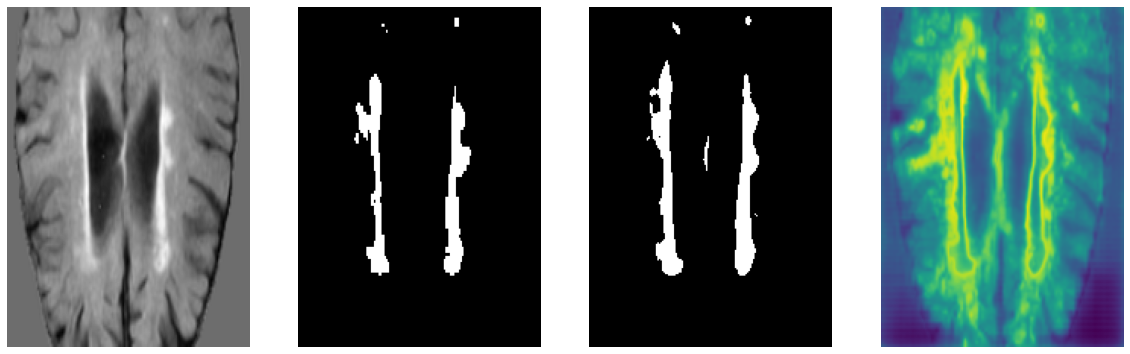

In [130]:
ind = 12
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.imshow(x1[ind][0,:,:],cmap='gray'); plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(y1[ind],cmap='gray'); plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(mean_p_hat.argmax(dim=1)[ind],cmap='gray'); plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(aus[ind].squeeze())
print(slice_dice(mean_p_hat[ind], y1[ind])); plt.axis('off')
plt.show()

In [128]:
samples = fixed_re_parametrization_trick(out['distribution'], 14)

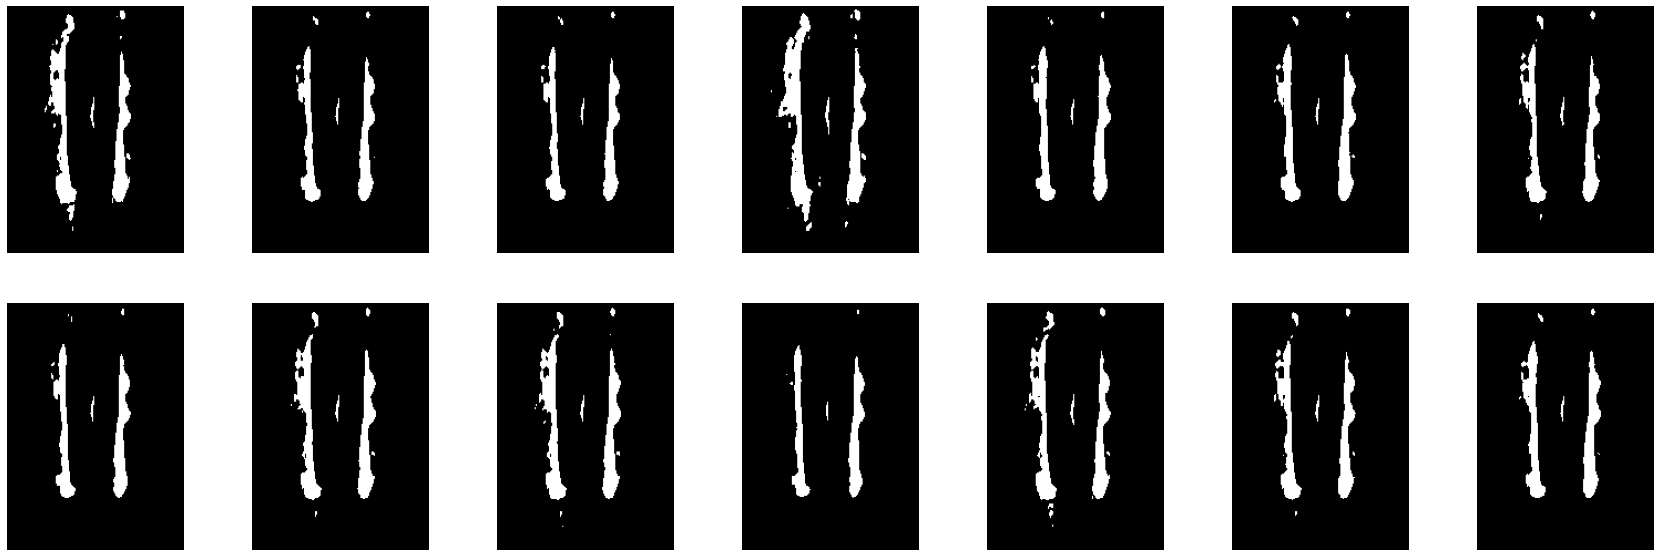

In [129]:
plt.figure(figsize=(30,10))
for i in range(len(samples)):
    logits = samples[i]
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    one_hot = get_one_hot_target(K, y1)
    mean_p_hat = get_mean_p_hat(alpha, S)
    alpha_modified = get_alpha_modified(alpha, one_hot)
    eus = epistemic_uncert(K, S)
    aus = aleotoric_uncert(alpha, S)
    dus = distributional_uncert(alpha, S)
    plt.subplot(2,7,i+1)
    plt.imshow(mean_p_hat.argmax(dim=1)[ind],cmap='gray'); plt.axis('off')

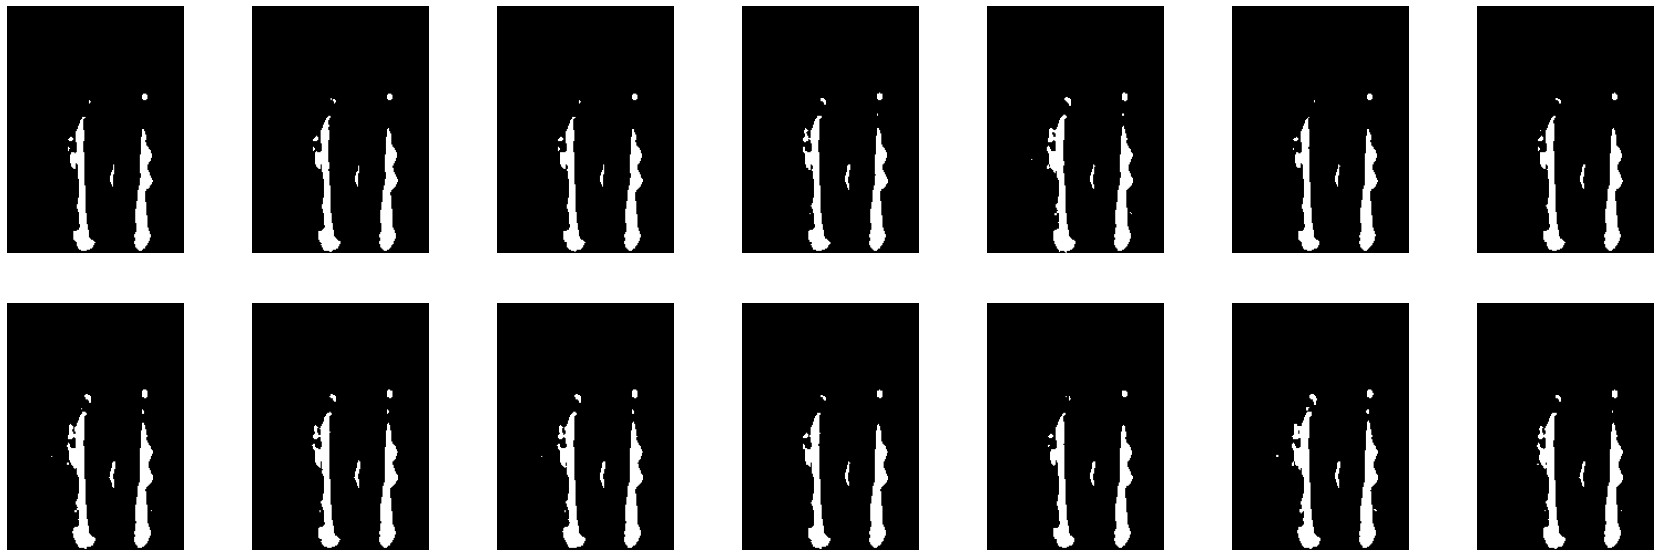

In [109]:
plt.figure(figsize=(30,10))
for i in range(len(samples)):
    logits = samples[i]
    evidence = softplus_evidence(logits)
    S = get_S(evidence)
    alpha = get_alpha(evidence)
    K = alpha.shape[1]
    one_hot = get_one_hot_target(K, y1)
    mean_p_hat = get_mean_p_hat(alpha, S)
    alpha_modified = get_alpha_modified(alpha, one_hot)
    eus = epistemic_uncert(K, S)
    aus = aleotoric_uncert(alpha, S)
    dus = distributional_uncert(alpha, S)
    plt.subplot(2,7,i+1)
    plt.imshow(mean_p_hat.argmax(dim=1)[ind],cmap='gray'); plt.axis('off')

In [110]:
out['cov_factor'].max(), out['cov_factor'].min(), out['cov_factor'].mean()

(tensor(7.0933), tensor(-9.8058), tensor(-0.0990))

In [111]:
out['logit_mean'].max(), out['logit_mean'].min(), out['logit_mean'].mean()

(tensor(50.4818), tensor(-67.6759), tensor(-3.2284))

In [112]:
out['cov_diag'].max(), out['cov_diag'].min(), out['cov_diag'].mean()

(tensor(2.0000e-05), tensor(1.0000e-05), tensor(1.4733e-05))

In [113]:
out['cov_factor'].shape

torch.Size([32, 20, 224, 160])

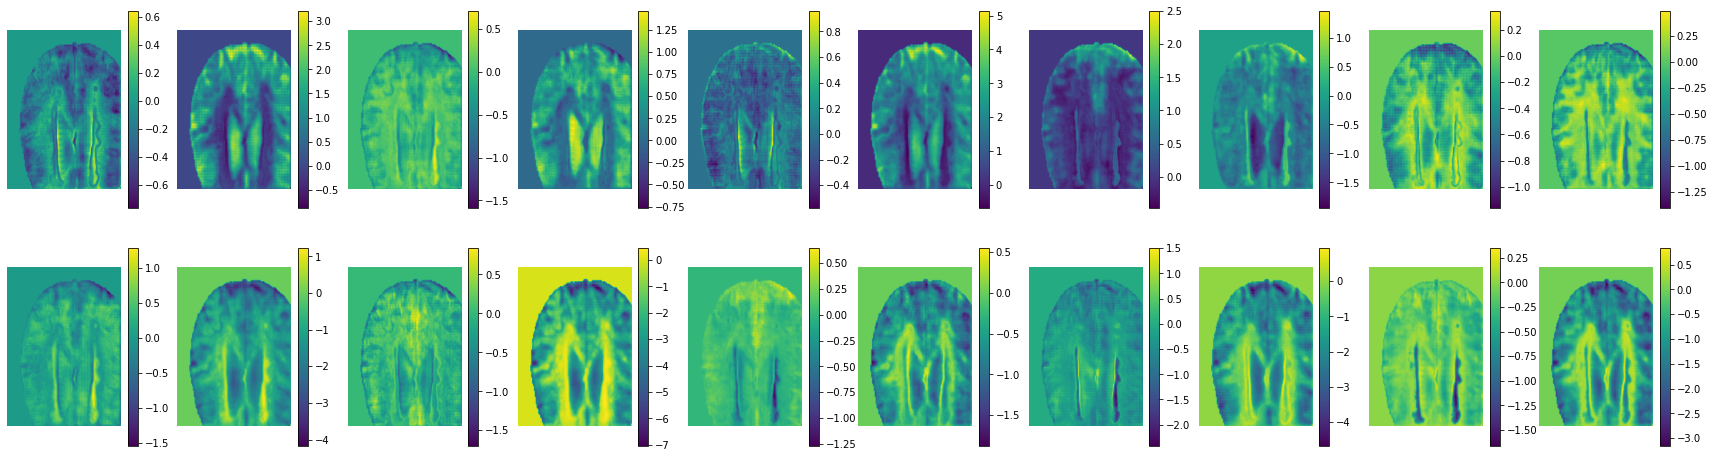

In [114]:
plt.figure(figsize=(30, 8))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(out['cov_factor'][ind][i]); plt.axis('off'); plt.colorbar()

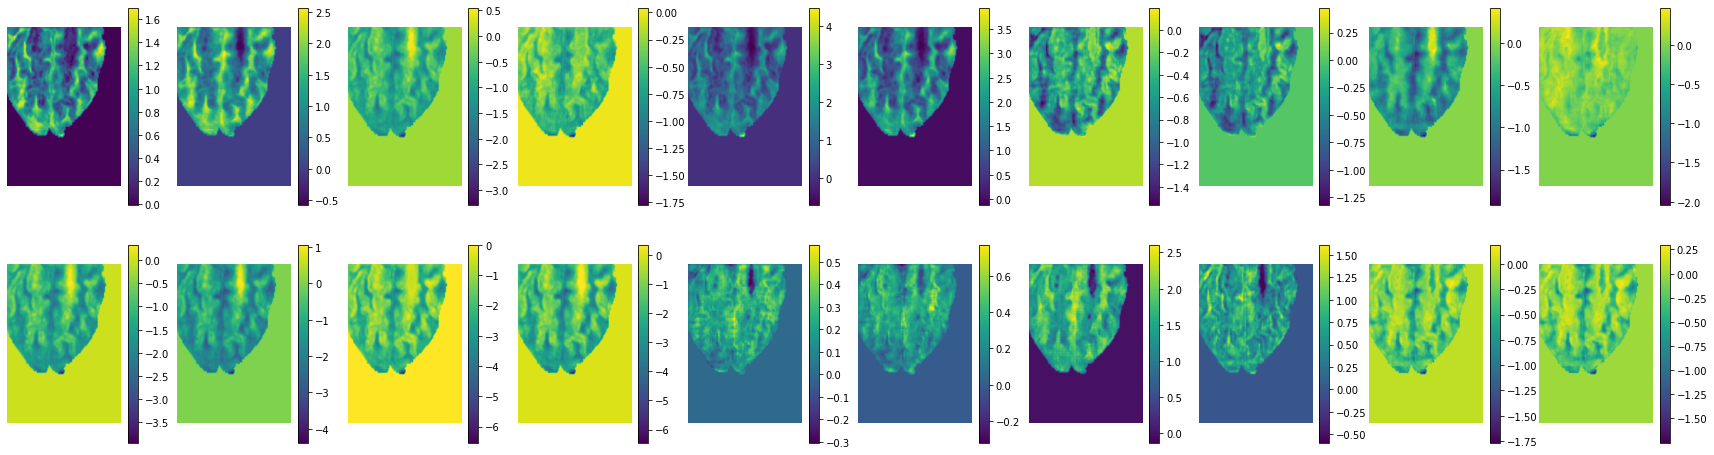

In [43]:
plt.figure(figsize=(30, 8))
for i in range(20):
    plt.subplot(2, 10, i+1)
    plt.imshow(out['cov_factor'][ind][i]); plt.axis('off'); plt.colorbar()

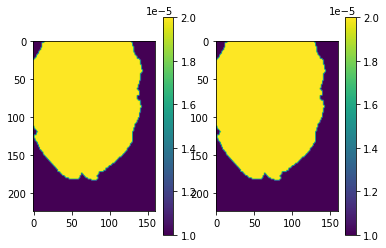

In [72]:
plt.subplot(1,2,1)
plt.imshow(out['cov_diag'][ind][0]); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(out['cov_diag'][ind][1]); plt.colorbar();

In [78]:
out['cov_diag'].unique()

tensor([1.0000e-05, 1.0001e-05, 1.0001e-05,  ..., 2.0000e-05, 2.0000e-05,
        2.0001e-05])

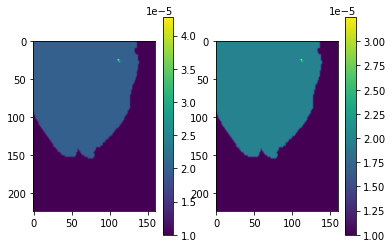

In [51]:
plt.subplot(1,2,1)
plt.imshow(out['cov_diag'][ind][0]); plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(out['cov_diag'][ind][1]); plt.colorbar();